In [31]:
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [25]:
params = {'max_depth':[5, 10, 15],
          'eta': [0.1, 0.2, 0.3, 0.5],
          'n_estimators': [50, 100, 200],
          'min_child_weight':[1, 2, 3, 5],
          'gamma': [1, 2, 3, 5]}

In [26]:
train_X = pd.read_csv("./data/train/train_x.csv")
train_y = pd.read_csv("./data/train/train_y.csv")

In [27]:
xgbr = XGBRegressor(objective="reg:squarederror",
                    eval_metric='rmse',
                    num_round=30,
                    silent = 0)

In [28]:
model = GridSearchCV(estimator=xgbr,
                     param_grid=params,
                     scoring='neg_mean_absolute_error',
                     cv=10,
                     verbose=1,
                     n_jobs=-1)

In [29]:
model.fit(train_X.values, train_y.values)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  5.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='rmse', gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=30, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15], 'eta': [0.1, 0.2, 0.3, 0.5], 'n_estimators': [50, 100, 200], 'min_child_weight': [1, 2, 3, 5], 'gamma': [1, 2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [33]:
if os.path.exists("./model") is False:
    os.mkdir("./model")
pickle.dump(model, open("./model/xgb.pkl", "wb"))
# model = pickle.load(open("xgb.pkl", "rb"))

In [34]:
df_x = pd.read_csv("./data/test/test_x.csv")
df_y = pd.read_csv("./data/test/test_y.csv")

In [35]:
y_pred = model.predict(df_x.values) # model.predict(df_x[train_X.columns].values)

In [36]:
df = pd.concat([df_x, df_y], axis=1)

In [37]:
df["TVD_pred"] = y_pred

In [38]:
df.rename(columns={"Z": "TVD"}, inplace=True)

In [39]:
print(f"XGBoost MAE score: {np.round(mean_absolute_error(df.TVD, df.TVD_pred))}m")
print(f"XGBoost R2 socre: {np.round(r2_score(df.TVD, df.TVD_pred), 4)}")

XGBoost MAE score: 87.0m
XGBoost R2 socre: 0.9979


In [40]:
df["model_error"] = df["TVD"] - df["TVD_pred"]

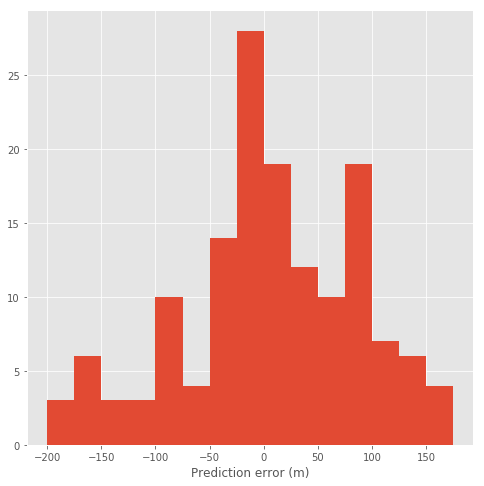

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.hist(df["model_error"], bins=np.arange(-200, 200,25))
plt.xlabel("Prediction error (m)")
plt.show()

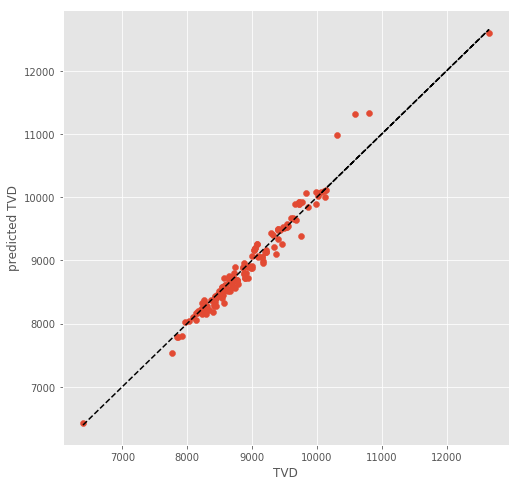

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(df.loc[df.TVD >1000].TVD, df.loc[df.TVD >1000].TVD_pred)
plt.plot(df.loc[df.TVD >1000].TVD, df.loc[df.TVD >1000].TVD, color="black", linestyle="--")
plt.xlabel("TVD")
plt.ylabel("predicted TVD")
plt.show()

In [51]:
df_global = pd.read_csv("global_test_df.csv")

In [52]:
df_global.rename(columns={"Z": "TVD"}, inplace=True)

In [53]:
df_global["TVD_pred"] = df["TVD_pred"]

In [54]:
if os.path.exists("model_predictions") is False:
    os.mkdir("./model_predictions")
df_global.to_csv("./model_predictions/xgb_predictions.csv")